In [218]:
import pykitti 
import numpy as np 
import matplotlib.pyplot as plt 
import utils.parse_tracklet_xml

from utils.visualize import load_dataset, load_tracklets_for_frames

In [219]:
basedir = 'data'

colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k',
}

In [220]:
frame = 10
date = '2011_09_26'
drive = '0001'
datadir = "data"
dataset = load_dataset(datadir, date, drive)


Drive: 2011_09_26_drive_0001_sync
Frame range: None


In [221]:
help(dataset)

Help on raw in module pykitti.raw object:

class raw(builtins.object)
 |  raw(base_path, date, drive, **kwargs)
 |  
 |  Load and parse raw data into a usable format.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, base_path, date, drive, **kwargs)
 |      Set the path and pre-load calibration data and timestamps.
 |  
 |  __len__(self)
 |      Return the number of frames loaded.
 |  
 |  get_cam0(self, idx)
 |      Read image file for cam0 (monochrome left) at the specified index.
 |  
 |  get_cam1(self, idx)
 |      Read image file for cam1 (monochrome right) at the specified index.
 |  
 |  get_cam2(self, idx)
 |      Read image file for cam2 (RGB left) at the specified index.
 |  
 |  get_cam3(self, idx)
 |      Read image file for cam3 (RGB right) at the specified index.
 |  
 |  get_gray(self, idx)
 |      Read monochrome stereo pair at the specified index.
 |  
 |  get_rgb(self, idx)
 |      Read RGB stereo pair at the specified index.
 |  
 |  get_velo(self, idx)
 |     

In [222]:
cam2_gen = dataset.get_cam2(0)

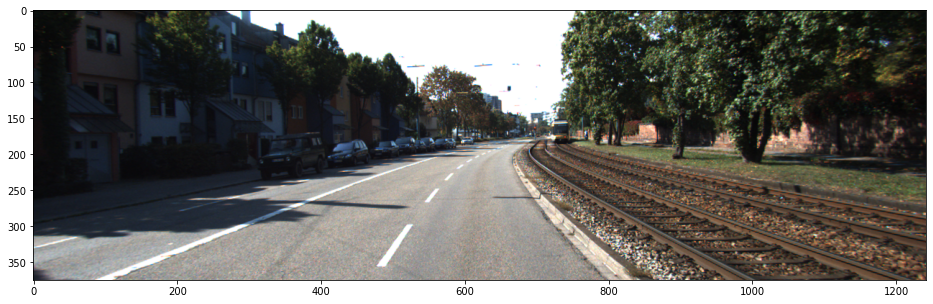

In [223]:
plt.figure(figsize=(16,9))
plt.imshow(cam2_gen)

In [350]:
xml_path = "/home/johann/dev/kitti-data-exploration/data/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml"
velo_to_cam_path = "/home/johann/dev/kitti-data-exploration/data/2011_09_26/calib_velo_to_cam.txt"

In [225]:
tracklets = parse_tracklet_xml.parseXML(xml_path)

Parsing tracklet file: /home/johann/dev/kitti-data-exploration/data/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml
File contains 15 tracklets
Loaded 15 tracklets.


In [226]:
print(tracklets[0])

[Tracklet over 14 frames for Car]


In [348]:
def cart2homogen(points3D):
    n = points3D.shape[0]
    homogen_points3D = np.hstack((points3D, np.ones((n, 1))))
    return homogen_points3D

In [354]:
def load_Rt_velo_to_cam(path: str):
    lines = []
    with open(path, 'r') as fp: 
        for line in fp.readlines():
            lines.append(line)
    lines = lines[1:3]
    # rotation matrix
    velo_to_cam_rotations = lines[0].split(' ')[1:]
    velo_to_cam_rotations = np.array([float(el.strip()) 
                                      for el in velo_to_cam_rotations]).reshape((3,3))
    # translation 
    velo_to_cam_translation = lines[1].split(' ')[1:]
    velo_to_cam_translation = np.array([float(el.strip()) 
                                        for el in velo_to_cam_translation]).reshape((3,1))
    Rt_velo_to_cam = np.hstack((velo_to_cam_rotations, velo_to_cam_translation))
    Rt_velo_to_cam = np.vstack((Rt_velo_to_cam, np.array([0, 0, 0, 1])))
    
    return Rt_velo_to_cam

In [357]:
def tracklets_velo2cam_2d(tracklets, dataset, velo_to_cam_path: str, n_frames: int, camera_id=2):
    tracklets_2d_boxes = {}
    tracklets_2d_boxes_types = {}
    
    for i in range(n_frames):
        tracklets_2d_boxes[i] = []
        tracklets_2d_boxes_types[i] = []
        
    R_rect_00 = dataset.calib.R_rect_00
    
    if camera_id == 0:
        P_rect = dataset.calib.P_rect_00
    elif camera_id == 1:
        P_rect = dataset.calib.P_rect_10
    elif camera_id == 2:
        P_rect = dataset.calib.P_rect_20
    elif camera_id == 3:
        P_rect = dataset.calib.P_rect_30
        
    Rt_velo_to_cam = load_Rt_velo_to_cam(velo_to_cam_path)
    
    for i, tracklet in enumerate(tracklets):
        
        h, w, l = tracklet.size
        # in velodyne coordinates around zero point and without orientation yet
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        
        for (translation, rotation, state, occlusion, 
             truncation, amtOcclusion, amtBorders, 
             absoluteFrameNumber) in tracklet:
            
            if truncation not in [0, 1]: # 0 -> in image, 1 -> truncated
                continue 
                
            yaw = rotation[2]
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            # rotation around z-axis 
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            # transform to homogenuous coordinates
            cornerPosInVeloHomo = cart2homogen(cornerPosInVelo.T)
            
            cornerPosInCameraHomo = Rt_velo_to_cam @ cornerPosInVeloHomo.T
            cornerPosInCameraHomo = R_rect_00 @ cornerPosInCameraHomo
            cornerPosInCameraHomo = P_rect @ cornerPosInCameraHomo
            
            cornerPosInCameraHomo = cornerPosInCameraHomo.T
            # transform to pixel coordinates
            cornerPosInCameraHomo[:,0] /= cornerPosInCameraHomo[:,2]
            cornerPosInCameraHomo[:,1] /= cornerPosInCameraHomo[:,2]
            cornerPosInCamera = cornerPosInCameraHomo[:,:2]
            
            tracklets_2d_boxes[absoluteFrameNumber] = tracklets_2d_boxes[absoluteFrameNumber] + [cornerPosInCamera]
            tracklets_2d_boxes_types[absoluteFrameNumber] = tracklets_2d_boxes_types[absoluteFrameNumber] + [tracklet.objectType]
    
    
    return tracklets_2d_boxes, tracklets_2d_boxes_types

In [358]:
tracklets_2d_boxes, tracklets_2d_boxes_types = tracklets_velo2cam_2d(tracklets, 
                                                                     dataset, 
                                                                     velo_to_cam_path, 
                                                                     n_frames=len(list(dataset.cam2)), 
                                                                     camera_id=2)

In [359]:
len(tracklets_2d_boxes)

108

In [360]:
len(tracklets_2d_boxes_types)

108

In [364]:
cam2_gen = np.asarray(dataset.get_cam2(0))
boxes2d = tracklets_2d_boxes.get(0)
cam2_gen.shape 

(375, 1242, 3)

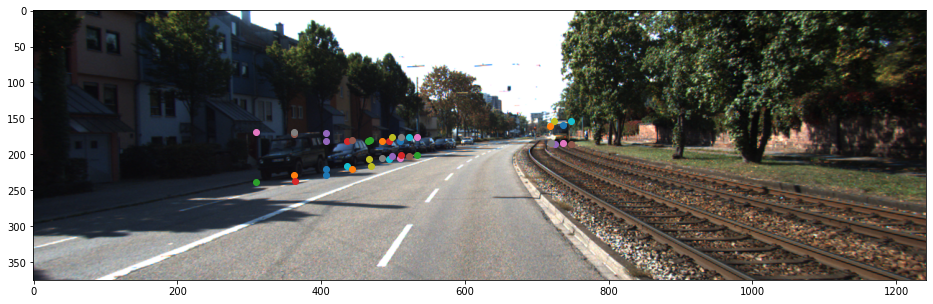

In [368]:
plt.figure(figsize=(16,9))
plt.imshow(cam2_gen)
for box in boxes2d:
    for point in box:
        plt.scatter(point[0], point[1])

In [227]:
h, w, l = tracklets[0].size
print("Height: {}".format(h))
print("Width: {}".format(w))
print("Length: {}".format(l))

Height: 2.1672349
Width: 1.7057118
Length: 4.3293562


In [268]:
translation = tracklets[0].trans[0]
translation

array([25.2125,  8.6034, -1.7922])

In [269]:
yaw = tracklets[0].rots[0][2]
yaw

-3.1842001424562025

In [270]:
# rotation around the y axis 
rotation_matrix = np.array([
    [np.cos(yaw), 0, np.sin(yaw)], 
    [0, 1, 0], 
    [-np.sin(yaw), 0, -np.cos(yaw)]
])

In [309]:
trackletBox = np.array([
    [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
    [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
    [0.0, 0.0, 0.0, 0.0, h, h, h, h]
])

In [271]:
x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2]
y_corners = [0,0,0,0,-h,-h,-h,-h]
z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2]

In [272]:
# rotate the corner coordinates
tracklet_box = np.vstack([x_corners, y_corners, z_corners])
tracklet_box

array([[ 2.1647,  2.1647, -2.1647, -2.1647,  2.1647,  2.1647, -2.1647,
        -2.1647],
       [ 0.    ,  0.    ,  0.    ,  0.    , -2.1672, -2.1672, -2.1672,
        -2.1672],
       [ 0.8529, -0.8529, -0.8529,  0.8529,  0.8529, -0.8529, -0.8529,
         0.8529]])

In [273]:
help(dataset.calib)

Help on CalibData in module pykitti.raw object:

class CalibData(builtins.tuple)
 |  CalibData(T_velo_imu, T_cam0_velo_unrect, P_rect_00, P_rect_10, P_rect_20, P_rect_30, R_rect_00, R_rect_10, R_rect_20, R_rect_30, T_cam0_velo, T_cam1_velo, T_cam2_velo, T_cam3_velo, K_cam0, K_cam1, K_cam2, K_cam3, b_gray, b_rgb, T_cam0_imu, T_cam1_imu, T_cam2_imu, T_cam3_imu)
 |  
 |  CalibData(T_velo_imu, T_cam0_velo_unrect, P_rect_00, P_rect_10, P_rect_20, P_rect_30, R_rect_00, R_rect_10, R_rect_20, R_rect_30, T_cam0_velo, T_cam1_velo, T_cam2_velo, T_cam3_velo, K_cam0, K_cam1, K_cam2, K_cam3, b_gray, b_rgb, T_cam0_imu, T_cam1_imu, T_cam2_imu, T_cam3_imu)
 |  
 |  Method resolution order:
 |      CalibData
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return self as a plain tuple.  Used by copy and pickle.
 |  
 |  __repr__(self)
 |      Return a nicely formatted representation string
 |  
 |  _asdict(self)
 |      Return a new dict

In [317]:
R_rect_00 = dataset.calib.R_rect_00
R_rect_00

array([[ 0.9999,  0.0098, -0.0074,  0.    ],
       [-0.0099,  0.9999, -0.0043,  0.    ],
       [ 0.0074,  0.0044,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [318]:
P_rect_20 = dataset.calib.P_rect_20
P_rect_20

array([[721.5377,   0.    , 609.5593,  44.8573],
       [  0.    , 721.5377, 172.854 ,   0.2164],
       [  0.    ,   0.    ,   1.    ,   0.0027]])

In [319]:
velo_to_cam = "/home/johann/dev/kitti-data-exploration/data/2011_09_26/calib_velo_to_cam.txt"
lines = []
with open(velo_to_cam, 'r') as fp: 
    for line in fp.readlines():
        lines.append(line)

lines

['calib_time: 15-Mar-2012 11:37:16\n',
 'R: 7.533745e-03 -9.999714e-01 -6.166020e-04 1.480249e-02 7.280733e-04 -9.998902e-01 9.998621e-01 7.523790e-03 1.480755e-02\n',
 'T: -4.069766e-03 -7.631618e-02 -2.717806e-01\n',
 'delta_f: 0.000000e+00 0.000000e+00\n',
 'delta_c: 0.000000e+00 0.000000e+00\n']

In [320]:
lines = lines[1:3]
lines

['R: 7.533745e-03 -9.999714e-01 -6.166020e-04 1.480249e-02 7.280733e-04 -9.998902e-01 9.998621e-01 7.523790e-03 1.480755e-02\n',
 'T: -4.069766e-03 -7.631618e-02 -2.717806e-01\n']

In [321]:
velo_to_cam_rotations = lines[0].split(' ')[1:]
velo_to_cam_rotations = np.array([float(el.strip()) for el in velo_to_cam_rotations]).reshape((3,3))
velo_to_cam_rotations

array([[ 0.0075, -1.    , -0.0006],
       [ 0.0148,  0.0007, -0.9999],
       [ 0.9999,  0.0075,  0.0148]])

In [322]:
velo_to_cam_translation = lines[1].split(' ')[1:]
velo_to_cam_translation = np.array([float(el.strip()) for el in velo_to_cam_translation]).reshape((3,1))
velo_to_cam_translation

array([[-0.0041],
       [-0.0763],
       [-0.2718]])

In [323]:
Rt_velo_to_cam = np.hstack((velo_to_cam_rotations, velo_to_cam_translation))
Rt_velo_to_cam

array([[ 0.0075, -1.    , -0.0006, -0.0041],
       [ 0.0148,  0.0007, -0.9999, -0.0763],
       [ 0.9999,  0.0075,  0.0148, -0.2718]])

In [324]:
Rt_velo_to_cam = np.vstack((Rt_velo_to_cam, np.array([0, 0, 0, 1])))
Rt_velo_to_cam

array([[ 0.0075, -1.    , -0.0006, -0.0041],
       [ 0.0148,  0.0007, -0.9999, -0.0763],
       [ 0.9999,  0.0075,  0.0148, -0.2718],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [326]:
trackletBox

array([[-2.1647, -2.1647,  2.1647,  2.1647, -2.1647, -2.1647,  2.1647,
         2.1647],
       [ 0.8529, -0.8529, -0.8529,  0.8529,  0.8529, -0.8529, -0.8529,
         0.8529],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  2.1672,  2.1672,  2.1672,
         2.1672]])

In [327]:
rotMat = np.array([
    [np.cos(yaw), -np.sin(yaw), 0.0],
    [np.sin(yaw), np.cos(yaw), 0.0],
    [0.0, 0.0, 1.0]
])

In [328]:
cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T

In [329]:
cornerPosInVelo.T

array([[27.3389,  7.6591, -1.7922],
       [27.4116,  9.3633, -1.7922],
       [23.0861,  9.5477, -1.7922],
       [23.0135,  7.8435, -1.7922],
       [27.3389,  7.6591,  0.3751],
       [27.4116,  9.3633,  0.3751],
       [23.0861,  9.5477,  0.3751],
       [23.0135,  7.8435,  0.3751]])

In [331]:
cornerPosInVeloHomo = cart2homogen(cornerPosInVelo.T)
cornerPosInVeloHomo

array([[27.3389,  7.6591, -1.7922,  1.    ],
       [27.4116,  9.3633, -1.7922,  1.    ],
       [23.0861,  9.5477, -1.7922,  1.    ],
       [23.0135,  7.8435, -1.7922,  1.    ],
       [27.3389,  7.6591,  0.3751,  1.    ],
       [27.4116,  9.3633,  0.3751,  1.    ],
       [23.0861,  9.5477,  0.3751,  1.    ],
       [23.0135,  7.8435,  0.3751,  1.    ]])

In [333]:
test = Rt_velo_to_cam @ cornerPosInVeloHomo.T
test.shape

(4, 8)

In [335]:
test.T

array([[-7.4559,  2.1259, 27.0944,  1.    ],
       [-9.1595,  2.1282, 27.1799,  1.    ],
       [-9.3764,  2.0643, 22.8565,  1.    ],
       [-7.6729,  2.062 , 22.771 ,  1.    ],
       [-7.4572, -0.0411, 27.1265,  1.    ],
       [-9.1608, -0.0388, 27.212 ,  1.    ],
       [-9.3778, -0.1027, 22.8886,  1.    ],
       [-7.6742, -0.105 , 22.8031,  1.    ]])

In [336]:
test = R_rect_00 @ test
test.shape 

(4, 8)

In [338]:
test.T

array([[-7.6361,  2.0834, 27.0475,  1.    ],
       [-9.3402,  2.1022, 27.1204,  1.    ],
       [-9.5256,  2.059 , 22.7952,  1.    ],
       [-7.8215,  2.0402, 22.7223,  1.    ],
       [-7.659 , -0.0835, 27.0701,  1.    ],
       [-9.3631, -0.0648, 27.143 ,  1.    ],
       [-9.5485, -0.108 , 22.8178,  1.    ],
       [-7.8444, -0.1268, 22.745 ,  1.    ]])

In [339]:
test = P_rect_20 @ test
test.shape 

(3, 8)

In [342]:
test.T

array([[11022.1595,  6178.7703,    27.0502],
       [ 9837.0358,  6204.9039,    27.1231],
       [ 7066.8075,  5426.075 ,    22.7979],
       [ 8251.9311,  5399.9413,    22.7251],
       [11019.4477,  4619.1165,    27.0729],
       [ 9834.324 ,  4645.2501,    27.1458],
       [ 7064.0957,  3866.4212,    22.8206],
       [ 8249.2193,  3840.2875,    22.7477]])

In [343]:
test = test.T
test[:,0] /= test[:,2]
test[:,1] /= test[:,2]
test = test[:,:2]

In [344]:
test[:,0] /= test[:,2]
test[:,1] /= test[:,2]
test

array([[407.4699, 228.4183,  27.0502],
       [362.681 , 228.7682,  27.1231],
       [309.9757, 238.0073,  22.7979],
       [363.1201, 237.6204,  22.7251],
       [407.0288, 170.6178,  27.0729],
       [362.2785, 171.1225,  27.1458],
       [309.5492, 169.4269,  22.8206],
       [362.6393, 168.8207,  22.7477]])

In [345]:
test = test[:,:2]
test

array([[407.4699, 228.4183],
       [362.681 , 228.7682],
       [309.9757, 238.0073],
       [363.1201, 237.6204],
       [407.0288, 170.6178],
       [362.2785, 171.1225],
       [309.5492, 169.4269],
       [362.6393, 168.8207]])

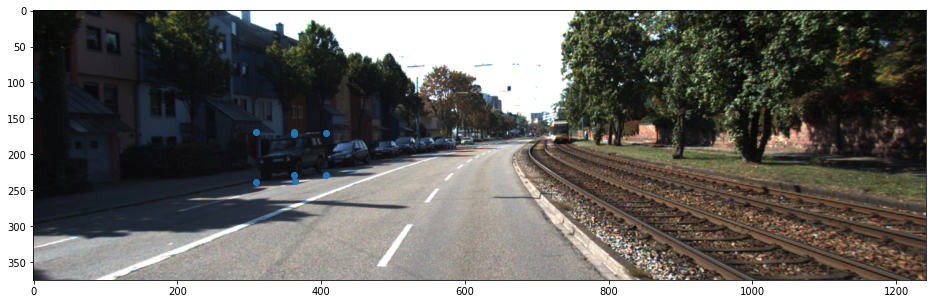

In [346]:
plt.figure(figsize=(16,9))
plt.imshow(cam2_gen)
plt.scatter(x=test[:,0], y=test[:,1])

In [294]:
tracklet_box_homo = cart2homogen(tracklet_box.T)
tracklet_box_homo

array([[ 2.1647,  0.    ,  0.8529,  1.    ],
       [ 2.1647,  0.    , -0.8529,  1.    ],
       [-2.1647,  0.    , -0.8529,  1.    ],
       [-2.1647,  0.    ,  0.8529,  1.    ],
       [ 2.1647, -2.1672,  0.8529,  1.    ],
       [ 2.1647, -2.1672, -0.8529,  1.    ],
       [-2.1647, -2.1672, -0.8529,  1.    ],
       [-2.1647, -2.1672,  0.8529,  1.    ]])

In [295]:
# In order to transform a homogeneous point X = [x y z 1]' from the velodyne
# coordinate system to a homogeneous point Y = [u v 1]' on image plane of
# camera xx, the following transformation has to be applied:
#    
# Y = P_rect_xx * R_rect_00 * (R|T)_velo_to_cam * X

In [296]:
# tracklet_box_homo_cam = P_rect_00 @ R_rect_00 @ Rt_velo_to_cam @ tracklet_box_homo

In [298]:
tracklet_box_homo.shape

(8, 4)

In [299]:
Rt_velo_to_cam.shape

(4, 4)

In [300]:
test = Rt_velo_to_cam @ tracklet_box_homo.T
test.shape

(4, 8)

In [301]:
test.T

array([[ 0.0117, -0.897 ,  1.9052,  1.    ],
       [ 0.0128,  0.8085,  1.88  ,  1.    ],
       [-0.0199,  0.7444, -2.4488,  1.    ],
       [-0.0209, -0.9611, -2.4235,  1.    ],
       [ 2.1789, -0.8986,  1.8889,  1.    ],
       [ 2.1799,  0.8069,  1.8637,  1.    ],
       [ 2.1473,  0.7428, -2.4651,  1.    ],
       [ 2.1463, -0.9627, -2.4398,  1.    ]])

In [302]:
test = R_rect_00 @ test
test.shape 

(4, 8)

In [303]:
test.T

array([[-0.0113, -0.9053,  1.9013,  1.    ],
       [ 0.0067,  0.8003,  1.8835,  1.    ],
       [ 0.0057,  0.755 , -2.4456,  1.    ],
       [-0.0123, -0.9505, -2.4278,  1.    ],
       [ 2.1558, -0.9281,  1.9011,  1.    ],
       [ 2.1738,  0.7774,  1.8832,  1.    ],
       [ 2.1728,  0.7321, -2.4459,  1.    ],
       [ 2.1548, -0.9734, -2.428 ,  1.    ]])

In [304]:
test = P_rect_20 @ test
test.shape 

(3, 8)

In [305]:
test = test.T
test

array([[ 1195.6854,  -324.302 ,     1.9041],
       [ 1197.8196,   903.216 ,     1.8863],
       [-1441.769 ,   122.2686,    -2.4429],
       [-1443.9032, -1105.2494,    -2.425 ],
       [ 2759.1754,  -340.87  ,     1.9038],
       [ 2761.3097,   886.648 ,     1.886 ],
       [  121.7211,   105.7005,    -2.4431],
       [  119.5868, -1121.8175,    -2.4253]])

In [306]:
test[:,0] /= test[:,2]
test[:,1] /= test[:,2]
test

array([[ 627.9575, -170.3189,    1.9041],
       [ 635.0238,  478.8398,    1.8863],
       [ 590.1971,  -50.0514,   -2.4429],
       [ 595.4158,  455.7667,   -2.425 ],
       [1449.2861, -179.0456,    1.9038],
       [1464.1168,  470.1234,    1.886 ],
       [ -49.8218,  -43.2644,   -2.4431],
       [ -49.308 ,  462.5474,   -2.4253]])

In [307]:
test = test[:, :2]
test

array([[ 627.9575, -170.3189],
       [ 635.0238,  478.8398],
       [ 590.1971,  -50.0514],
       [ 595.4158,  455.7667],
       [1449.2861, -179.0456],
       [1464.1168,  470.1234],
       [ -49.8218,  -43.2644],
       [ -49.308 ,  462.5474]])

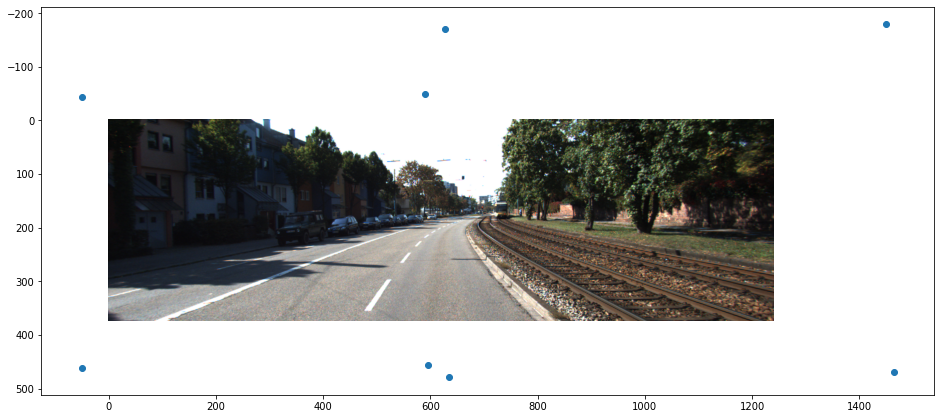

In [308]:
plt.figure(figsize=(16,9))
plt.imshow(cam2_gen)
plt.scatter(x=test[:,0], y=test[:,1])

In [182]:
Rt_velo_to_cam.shape

(4, 4)

In [180]:
P_rect_00.shape

(3, 4)

In [181]:
R_rect_00.shape

(4, 4)

In [183]:
tracklet_box_homo.shape

(8, 4)

In [108]:
corners_3d_cam2 = np.dot(rotation_matrix, tracklet_box)
corners_3d_cam2

array([[-2.1264, -2.199 ,  2.1264,  2.199 , -2.1264, -2.199 ,  2.1264,
         2.199 ],
       [ 0.    ,  0.    ,  0.    ,  0.    , -2.1672, -2.1672, -2.1672,
        -2.1672],
       [ 0.7599, -0.9443, -0.7599,  0.9443,  0.7599, -0.9443, -0.7599,
         0.9443]])

In [109]:
corners_3d_cam2.shape

(3, 8)

In [110]:
translation = np.vstack([x, y, z])
translation

array([[25.2125],
       [ 8.6034],
       [-1.7922]])

In [111]:
translations = np.tile(translation.T, (8,1))
translations.shape

(8, 3)

In [112]:
corners_3d_cam2 = corners_3d_cam2.T
corners_3d_cam2

array([[-2.1264,  0.    ,  0.7599],
       [-2.199 ,  0.    , -0.9443],
       [ 2.1264,  0.    , -0.7599],
       [ 2.199 ,  0.    ,  0.9443],
       [-2.1264, -2.1672,  0.7599],
       [-2.199 , -2.1672, -0.9443],
       [ 2.1264, -2.1672, -0.7599],
       [ 2.199 , -2.1672,  0.9443]])

In [113]:
corners_3d_cam2 += translations
corners_3d_cam2

array([[23.0861,  8.6034, -1.0323],
       [23.0135,  8.6034, -2.7364],
       [27.3389,  8.6034, -2.552 ],
       [27.4116,  8.6034, -0.8479],
       [23.0861,  6.4362, -1.0323],
       [23.0135,  6.4362, -2.7364],
       [27.3389,  6.4362, -2.552 ],
       [27.4116,  6.4362, -0.8479]])

In [114]:
# 3d points in rectified camera coordinates
corners_3d_cam2

array([[23.0861,  8.6034, -1.0323],
       [23.0135,  8.6034, -2.7364],
       [27.3389,  8.6034, -2.552 ],
       [27.4116,  8.6034, -0.8479],
       [23.0861,  6.4362, -1.0323],
       [23.0135,  6.4362, -2.7364],
       [27.3389,  6.4362, -2.552 ],
       [27.4116,  6.4362, -0.8479]])

In [115]:
def cart2homogen(points3D):
    n = points3D.shape[0]
    homogen_points3D = np.hstack((points3D, np.ones((n, 1))))
    return homogen_points3D

In [116]:
corners_3d_cam2_hom = cart2homogen(corners_3d_cam2)
corners_3d_cam2_hom.shape

(8, 4)

In [117]:
corners_3d_cam2_hom

array([[23.0861,  8.6034, -1.0323,  1.    ],
       [23.0135,  8.6034, -2.7364,  1.    ],
       [27.3389,  8.6034, -2.552 ,  1.    ],
       [27.4116,  8.6034, -0.8479,  1.    ],
       [23.0861,  6.4362, -1.0323,  1.    ],
       [23.0135,  6.4362, -2.7364,  1.    ],
       [27.3389,  6.4362, -2.552 ,  1.    ],
       [27.4116,  6.4362, -0.8479,  1.    ]])

In [95]:
help(dataset.calib)

Help on CalibData in module pykitti.raw object:

class CalibData(builtins.tuple)
 |  CalibData(T_velo_imu, T_cam0_velo_unrect, P_rect_00, P_rect_10, P_rect_20, P_rect_30, R_rect_00, R_rect_10, R_rect_20, R_rect_30, T_cam0_velo, T_cam1_velo, T_cam2_velo, T_cam3_velo, K_cam0, K_cam1, K_cam2, K_cam3, b_gray, b_rgb, T_cam0_imu, T_cam1_imu, T_cam2_imu, T_cam3_imu)
 |  
 |  CalibData(T_velo_imu, T_cam0_velo_unrect, P_rect_00, P_rect_10, P_rect_20, P_rect_30, R_rect_00, R_rect_10, R_rect_20, R_rect_30, T_cam0_velo, T_cam1_velo, T_cam2_velo, T_cam3_velo, K_cam0, K_cam1, K_cam2, K_cam3, b_gray, b_rgb, T_cam0_imu, T_cam1_imu, T_cam2_imu, T_cam3_imu)
 |  
 |  Method resolution order:
 |      CalibData
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return self as a plain tuple.  Used by copy and pickle.
 |  
 |  __repr__(self)
 |      Return a nicely formatted representation string
 |  
 |  _asdict(self)
 |      Return a new dict

In [118]:
T_cam2_velo = dataset.calib.T_cam2_velo
T_cam2_velo.shape

(4, 4)

In [119]:
T_cam2_velo

array([[ 0.0002, -0.9999, -0.0106,  0.0594],
       [ 0.0104,  0.0106, -0.9999, -0.0751],
       [ 0.9999,  0.0001,  0.0105, -0.2721],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [120]:
test = np.dot(corners_3d_cam2_hom, T_cam2_velo)
test.shape

(8, 4)

In [121]:
test

array([[ -0.9369, -22.9941,  -8.8571,   2.0054],
       [ -2.641 , -22.9216,  -8.8741,   2.4648],
       [ -2.4556, -27.2468,  -8.9179,   2.6715],
       [ -0.7515, -27.3192,  -8.9009,   2.212 ],
       [ -0.9595, -23.017 ,  -6.6901,   2.1682],
       [ -2.6636, -22.9445,  -6.7071,   2.6276],
       [ -2.4782, -27.2697,  -6.7509,   2.8343],
       [ -0.7741, -27.3421,  -6.7339,   2.3748]])

In [122]:
# projection matrix from rect camera 3d coordinates to image 2d coordinates
projection_matrix = dataset.calib.P_rect_20.T
projection_matrix.shape

(4, 3)

In [123]:
projection_matrix

array([[721.5377,   0.    ,   0.    ],
       [  0.    , 721.5377,   0.    ],
       [609.5593, 172.854 ,   1.    ],
       [ 44.8573,   0.2164,   0.0027]])

In [124]:
points2D = np.dot(test, projection_matrix)
points2D.shape

(8, 3)

In [125]:
points2D

array([[ -5984.9811, -18121.6402,     -8.8516],
       [ -7204.324 , -18072.22  ,     -8.8674],
       [ -7087.95  , -21200.5079,     -8.9106],
       [ -5868.6071, -21249.9282,     -8.8948],
       [ -4673.1071, -17763.5526,     -6.6842],
       [ -5892.4501, -17714.1324,     -6.6999],
       [ -5776.0761, -20842.4203,     -6.7431],
       [ -4556.7331, -20891.8406,     -6.7273]])

In [126]:
points2D[:,0] /= points2D[:,2]
points2D

array([[   676.1473, -18121.6402,     -8.8516],
       [   812.4528, -18072.22  ,     -8.8674],
       [   795.454 , -21200.5079,     -8.9106],
       [   659.7803, -21249.9282,     -8.8948],
       [   699.1325, -17763.5526,     -6.6842],
       [   879.479 , -17714.1324,     -6.6999],
       [   856.5869, -20842.4203,     -6.7431],
       [   677.3447, -20891.8406,     -6.7273]])

In [127]:
points2D[:,1] /= points2D[:,2]
points2D

array([[ 676.1473, 2047.2744,   -8.8516],
       [ 812.4528, 2038.0575,   -8.8674],
       [ 795.454 , 2379.2533,   -8.9106],
       [ 659.7803, 2389.0308,   -8.8948],
       [ 699.1325, 2657.5631,   -6.6842],
       [ 879.479 , 2643.927 ,   -6.6999],
       [ 856.5869, 3090.9121,   -6.7431],
       [ 677.3447, 3105.5093,   -6.7273]])

In [128]:
points2D = points2D[:, :2]
points2D

array([[ 676.1473, 2047.2744],
       [ 812.4528, 2038.0575],
       [ 795.454 , 2379.2533],
       [ 659.7803, 2389.0308],
       [ 699.1325, 2657.5631],
       [ 879.479 , 2643.927 ],
       [ 856.5869, 3090.9121],
       [ 677.3447, 3105.5093]])

In [ ]:

point_cam0 = dataset.calib.T_cam0_velo.dot(point_velo)

In [35]:
dataset.calib

CalibData(T_velo_imu=array([[ 1.    ,  0.0008, -0.002 , -0.8087],
       [-0.0008,  0.9999, -0.0148,  0.3196],
       [ 0.002 ,  0.0148,  0.9999, -0.7997],
       [ 0.    ,  0.    ,  0.    ,  1.    ]]), T_cam0_velo_unrect=array([[ 0.0075, -1.    , -0.0006, -0.0041],
       [ 0.0148,  0.0007, -0.9999, -0.0763],
       [ 0.9999,  0.0075,  0.0148, -0.2718],
       [ 0.    ,  0.    ,  0.    ,  1.    ]]), P_rect_00=array([[721.5377,   0.    , 609.5593,   0.    ],
       [  0.    , 721.5377, 172.854 ,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]]), P_rect_10=array([[ 721.5377,    0.    ,  609.5593, -387.5744],
       [   0.    ,  721.5377,  172.854 ,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]]), P_rect_20=array([[721.5377,   0.    , 609.5593,  44.8573],
       [  0.    , 721.5377, 172.854 ,   0.2164],
       [  0.    ,   0.    ,   1.    ,   0.0027]]), P_rect_30=array([[ 721.5377,    0.    ,  609.5593, -339.5242],
       [   0.    ,  721.5377,  172.854 ,    

In [16]:
tracklet_rects, tracklet_types = load_tracklets_for_frames(
    len(list(dataset.velo)), 
    'data/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(date, date, drive), 
)

Parsing tracklet file: data/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml
File contains 15 tracklets
Loaded 15 tracklets.


In [19]:
tracklet_rects[0]

[array([[27.3389, 27.4116, 23.0861, 23.0135, 27.3389, 27.4116, 23.0861,
         23.0135],
        [ 7.6591,  9.3633,  9.5477,  7.8435,  7.6591,  9.3633,  9.5477,
          7.8435],
        [-1.7922, -1.7922, -1.7922, -1.7922,  0.3751,  0.3751,  0.3751,
          0.3751]]),
 array([[35.6424, 35.7567, 31.6542, 31.5399, 35.6424, 35.7567, 31.6542,
         31.5399],
        [ 6.9831,  8.5805,  8.8741,  7.2767,  6.9831,  8.5805,  8.8741,
          7.2767],
        [-1.7324, -1.7324, -1.7324, -1.7324,  0.0005,  0.0005,  0.0005,
          0.0005]]),
 array([[44.9793, 45.1116, 41.0147, 40.8825, 44.9793, 45.1116, 41.0147,
         40.8825],
        [ 6.2294,  7.8517,  8.1856,  6.5633,  6.2294,  7.8517,  8.1856,
          6.5633],
        [-1.4932, -1.4932, -1.4932, -1.4932, -0.0281, -0.0281, -0.0281,
         -0.0281]]),
 array([[ 74.8908,  74.5948,  97.7034,  97.9994,  74.8908,  74.5948,
          97.7034,  97.9994],
        [-11.8417, -14.1884, -17.1034, -14.7568, -11.8417, -14.1884,
       